## Q1

**Define Gaussian and stochastic processes generally**

A Stochastic Process is a collection of general random variables indexed by time or another parameter that represent a system that evolves under randomness. 

$$ X: T \times \Omega \to \mathbb{R} $$

where:

$T$ is an index set (e.g., time)

$\Omega$ is the sample space in a probability space

$X(t)$ is a random variable at index t


Some examples are:

Markov Processes: The future state depends on only the present state, not past states (such as geometric brownian motion)

Martingales: A process where the conditional expectation of the next value equals the present value.


A Gaussian process is a type of stochastic process where a finite collection of random variables follow a multivariate normal distribution. A gaussian process is defined by:

Mean function:

$m(t) = \mathbb{E}[X(t)]$

Variance function:

$k(t, t') = \text{Cov}(X(t), X(t'))$


Formally, a stochastic process $ X(t) $ is a Gaussian Process if for any finite set $ \{t_1, ..., t_n\} $, the vector $(X(t_1), ..., X(t_n))$ follows a multivariate normal distribution.




**Define Variational Inference using Evidence Lower Bound (ELBO)**

Variational Inference (VI) is a technique for approximating intractable posterior distributions in Bayesian models. Instead of direct Bayesian inference, which often requires computationally expensive methods like Markov Chain Monte Carlo (MCMC), VI turns the inference problem into an optimization problem


Variational Inference (VI) approximates intractable posterior distributions in Bayesian models by optimizing a simpler distribution. Instead of computing the exact posterior:

$$
p(Z \mid X) = \frac{p(X, Z)}{p(X)} $$

where the evidence (marginal likelihood) is:

$$
p(X) = \int p(X, Z) dZ $$

we introduce a variational distribution $q(Z)$ and minimize the KL divergence:

$$
\text{KL}(q(Z) \parallel p(Z \mid X)) = \mathbb{E}_{q(Z)} \left[ \log \frac{q(Z)}{p(Z \mid X)} \right]
$$

Since $ p(X)$ is intractable, we instead maximize the $\textbf{Evidence Lower Bound (ELBO)}$, derived as:

$$
\log p(X) = \mathbb{E}_{q(Z)} \left[ \log \frac{p(X, Z)}{q(Z)} \right] + \text{KL}(q(Z) \parallel p(Z \mid X))
$$

Since KL divergence is non-negative, we obtain:

$$
\log p(X) \geq \mathbb{E}_{q(Z)} [\log p(X, Z)] - \mathbb{E}_{q(Z)} [\log q(Z)]
$$

which defines the ELBO:

$$
\mathcal{L}(q) = \mathbb{E}_{q(Z)} [\log p(X, Z)] - \mathbb{E}_{q(Z)} [\log q(Z)]
$$

Thus, the Evidence Lower Bound (ELBO) serves as an optimization objective in variational inference, balancing the trade-off between fitting the observed data and maintaining a diverse approximation of the true posterior distribution to make inference computationally feasible.



## Q2

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs, lengthscale, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.


array([<Axes: title={'center': 'coeffs'}>,
       <Axes: title={'center': 'lengthscale'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

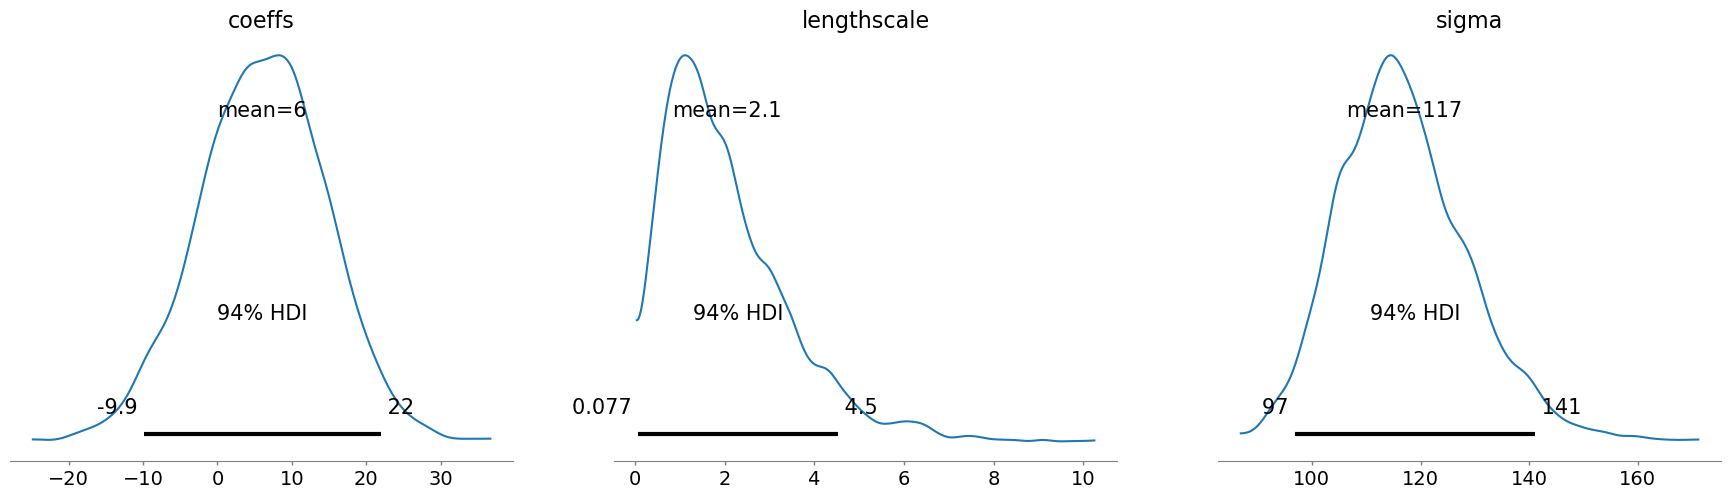

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


# Generating synthetic data: house prices vs. square footage
np.random.seed(42)
X = np.linspace(500, 4000, 100)  # Square footage
y = 50 + 0.05 * X + np.random.normal(0, 20, size=len(X))  # House prices

# **Limiting to a small subset (e.g., first 20 observations)**
num_obs = 50
X_small = X[:num_obs]
y_small = y[:num_obs]

# Standardizing X for better GP performance
X_small = (X_small - np.mean(X_small)) / np.std(X_small)

# Building the Gaussian Process model
with pm.Model() as model:
    # Defining mean and covariance functions
    mean_func = pm.gp.mean.Linear(coeffs=pm.Normal("coeffs", mu=0, sigma=10))
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=pm.Gamma("lengthscale", alpha=2, beta=1))

    # Defining the GP
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)

    # Likelihood
    sigma = pm.HalfCauchy("sigma", beta=3)
    y_obs = gp.marginal_likelihood("y_obs", X=X_small[:, None], y=y_small, noise=sigma)

    # Inference
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)

# Plotting results
az.plot_posterior(trace)


 **Defining the Gaussian process model**
 
For the data, we simulate synthetic data. We have square footage as X and house price as Y which is a linear model of X with a Gaussian error term. Thus, for this Gaussian process we are using a linear model to define the mean function. We standardize the data so as to ensure numerical stability.

With PyMC, a Gaussian Process model is constructed within a probabilistic modeling framework. The GP model consists of three main components: the mean function, the covariance function, and the likelihood function.

**Mean Function**

The mean function represents the expected value of the output variable given the input. In this case, a linear mean function is used, where the slope parameter follows a normal prior distribution with mean 0 and standard deviation 10. This prior allows for flexibility in capturing linear trends in the data while regularizing extreme values.

**Covariance Function**

The covariance function, also known as the kernel, defines the relationship between data points. The Exponentiated Quadratic (ExpQuad) covariance function, also referred to as the Radial Basis Function (RBF) kernel, is chosen. This kernel models smooth functions and ensures that nearby points are more strongly correlated than distant ones. The kernel includes a lengthscale parameter, which controls how quickly the correlation between points decays. The lengthscale is assigned a Gamma prior distribution to keep it positive and allow it to adapt to the underlying structure of the data.

**Likelihood Function**

The likelihood function specifies how the observed data is generated given the GP model. In this case, the observations are assumed to be normally distributed around the GP's predicted mean, with an additional noise term modeled as a Half-Cauchy distribution. This ensures that the noise term remains positive and can account for uncertainty in the data.


We then visualize the posterior distributions for mean, covariance, and our error term

**interpretation of Posterior plots**

As we can see, our coefficients follow a normal distribution with a 94% probability that they fall between -9.9 and 22 (flexible range). 

As we move on to our covariance/lengthscale distribution, there is a 94% probability that the value for lengthscale falls between 0.077 and 4.5.

Finally, for our noise term there is a 94% probability that the value falls between 97 and 141.




In [2]:
az.summary(trace, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeffs,6.01941,8.55030,-9.85396,22.01403,0.14107,0.12916,3683.79180,2800.86759,0.99946
lengthscale,2.05013,1.40161,0.07715,4.52572,0.02334,0.02870,3070.83278,2045.12026,1.00044
sigma,116.89242,11.97876,96.93505,141.14394,0.21101,0.19283,3298.20849,2757.98788,0.99993


As we can see, all our r_hat values are 1 or very close to 1. This signifies good convergence for all our parameters. However, the ess_bulk is less than 50% of total iterations suggesting that there can be improvements in the chain. We can potentially choose better priors that explore more of the parameter space or a less strict target_accept to ensure the dependency structure is overcome.

## Q3

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:


# Step 1: Generating synthetic data
np.random.seed(42)
X = np.linspace(500, 4000, 200)  # Square footage from 500 to 4000
y = (50 + 0.05 * X + np.random.normal(0, 20, size=len(X)) > 200).astype(int)  # Binary classification: if price > 200

# Step 2: Train/test split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1))  # Reshape for scaler
X_test = scaler.transform(X_test.reshape(-1, 1))

# Step 3: Defining the Neural Network model using PyMC
with pm.Model() as neural_network:
    # Define priors for weights and biases
    w1 = pm.Normal("w1", mu=0, sigma=10, shape=(1, 5))
    b1 = pm.Normal("b1", mu=0, sigma=10, shape=(5,))
    w2 = pm.Normal("w2", mu=0, sigma=10, shape=(5, 1))
    b2 = pm.Normal("b2", mu=0, sigma=10, shape=(1,))
    
    # Ensuring X_train is reshaped correctly
    X_train = X_train.reshape(-1, 1)  

    # Hidden layer with tanh activation
    hidden = pm.math.tanh(pm.math.dot(X_train, w1) + b1)

    # Output layer with sigmoid activation
    output = pm.math.sigmoid(pm.math.dot(hidden, w2) + b2)

    # Ensuring y_train is reshaped correctly
    y_train = y_train.reshape(-1, 1)

    # Likelihood function for binary classification
    likelihood = pm.Bernoulli("y", p=output, observed=y_train)

    # Fitting using Variational Inference
    approx = pm.fit(n=10000, method="advi")


# Step 5: Posterior Predictive Sampling
with neural_network:
    trace = approx.sample(1000)




Finished [100%]: Average Loss = 144.5


This demonstrates a Bayesian neural network (BNN) using variational inference (VI) in PyMC to classify houses based on square footage. Unlike traditional neural networks, a BNN treats weights and biases as probability distributions, allowing for uncertainty estimation in predictions.

We begin by generating synthetic data, where square footage serves as the input feature and the target variable indicates whether a house's price exceeds a threshold. The dataset is standardized for numerical stability, then split into training and testing sets.

The neural network consists of an input layer, a hidden layer with five neurons, and a single output neuron. Priors for weights and biases are modeled using normal distributions centered at zero, ensuring flexibility in parameter estimation. The hidden layer applies the tanh activation function, introducing non-linearity, while the output layer uses a sigmoid function to convert raw scores into probabilities.

For classification, we define a Bernoulli likelihood, linking the predicted probabilities to observed labels. To train the model, we employ Automatic Differentiation Variational Inference (ADVI), which approximates the posterior distribution of weights and biases by solving an optimization problem instead of using traditional sampling techniques. The model is trained for 10,000 iterations, refining the variational approximation to maximize the evidence lower bound (ELBO).

After inference, we extract posterior means for the weights and biases to make deterministic predictions on the test set. A forward pass through the trained network computes hidden layer activations, applies non-linearity, and outputs probabilities, which are then thresholded at 0.5 to classify houses. The model’s accuracy is computed by comparing predicted labels with actual labels.

This Bayesian approach enhances interpretability by quantifying uncertainty in predictions, making it particularly useful for financial and risk-sensitive applications.









Accuracy: 72.50%


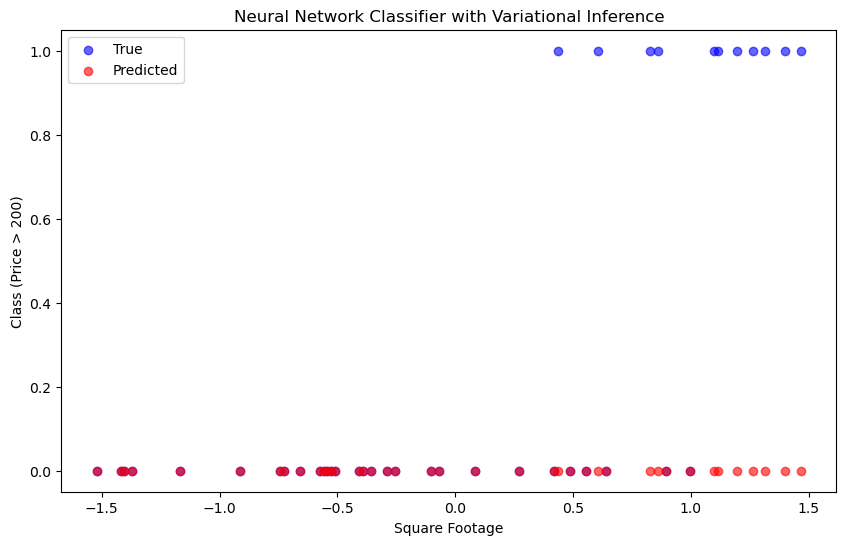

In [5]:
 #Step 6: Evaluating the model
# Extracting posterior means from the trace
w1_mean = trace.posterior["w1"].mean(dim=("chain", "draw")).values  # Shape: (1, 5)
b1_mean = trace.posterior["b1"].mean(dim=("chain", "draw")).values  # Shape: (5,)
w2_mean = trace.posterior["w2"].mean(dim=("chain", "draw")).values  # Shape: (5, 1)
b2_mean = trace.posterior["b2"].mean(dim=("chain", "draw")).values  # Shape: (1,)

# Forward pass through the trained neural network
hidden_layer = np.tanh(X_test @ w1_mean + b1_mean)
y_pred = 1 / (1 + np.exp(-(hidden_layer @ w2_mean + b2_mean)))  # Sigmoid activation
y_pred_class = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels

# Calculating accuracy
accuracy = np.mean(y_pred_class.flatten() == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Step 7: Visualizing the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label="True", color="blue", alpha=0.6)
plt.scatter(X_test, y_pred_class, label="Predicted", color="red", alpha=0.6)
plt.xlabel("Square Footage")
plt.ylabel("Class (Price > 200)")
plt.legend()
plt.title("Neural Network Classifier with Variational Inference")
plt.show()

Based on our neural network model, we achieve a 72% accuracy in classifying whether the price in our data is above or below 200. The following plot depicts the number of correct and incorrect predictions made by the neural network. There are only two potential predictions, 1 and 0.

As per the model, square footage from -1.5 to around 0.5 generally correctly predicts whether price > 200. However, square footage 0.5 and above does not correctly classify.